In [3]:
%pip install matplotlib seaborn scikit-learn imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import pickle

sns.set(style="whitegrid")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
df = pd.read_csv("../data/credit_risk_data.csv")
df.head()


,Age,Income,EmploymentType,LoanAmount,LoanDuration,CreditScore,PreviousDefaults,Collateral,Dependents,MaritalStatus,Risk
0,23,35967,Salaried,17861,24,607,0,Yes,4,Single,High
1,24,30617,Business,6488,24,609,0,Yes,4,Single,High
2,36,50476,Business,19164,36,757,1,No,2,Married,High
3,35,58230,Salaried,33941,36,576,0,Yes,2,Married,High
4,24,29658,Business,14588,60,581,2,Yes,4,Married,High


In [5]:
print("Shape:", df.shape)
df.info()
df.isnull().sum()


Shape: (100, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               100 non-null    int64 
 1   Income            100 non-null    int64 
 2   EmploymentType    100 non-null    object
 3   LoanAmount        100 non-null    int64 
 4   LoanDuration      100 non-null    int64 
 5   CreditScore       100 non-null    int64 
 6   PreviousDefaults  100 non-null    int64 
 7   Collateral        100 non-null    object
 8   Dependents        100 non-null    int64 
 9   MaritalStatus     100 non-null    object
 10  Risk              100 non-null    object
dtypes: int64(7), object(4)
memory usage: 8.7+ KB


Age                 0
Income              0
EmploymentType      0
LoanAmount          0
LoanDuration        0
CreditScore         0
PreviousDefaults    0
Collateral          0
Dependents          0
MaritalStatus       0
Risk                0
dtype: int64

In [6]:
# EmploymentType, Collateral, MaritalStatus, Risk
cat_cols = ["EmploymentType", "Collateral", "MaritalStatus"]

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Encode target variable
df_encoded["Risk"] = df_encoded["Risk"].map({"Low":0, "High":1})

df_encoded.head()


,Age,Income,LoanAmount,LoanDuration,CreditScore,PreviousDefaults,Dependents,Risk,EmploymentType_Salaried,Collateral_Yes,MaritalStatus_Married,MaritalStatus_Single
0,23,35967,17861,24,607,0,4,1,True,True,False,True
1,24,30617,6488,24,609,0,4,1,False,True,False,True
2,36,50476,19164,36,757,1,2,1,False,False,True,False
3,35,58230,33941,36,576,0,2,1,True,True,True,False
4,24,29658,14588,60,581,2,4,1,False,True,True,False


In [7]:
# Debt-to-Income Ratio
df_encoded["DebtIncomeRatio"] = df_encoded["LoanAmount"] / df_encoded["Income"]

# Total Obligation Ratio (Loan + PreviousDefaults*some_factor) / Income
df_encoded["TotalObligationRatio"] = (df_encoded["LoanAmount"] + df_encoded["PreviousDefaults"]*10000) / df_encoded["Income"]

# Age Groups
bins = [20, 30, 40, 50, 60, 70]
labels = ["20-30","30-40","40-50","50-60","60-70"]
df_encoded["AgeGroup"] = pd.cut(df_encoded["Age"], bins=bins, labels=labels)
df_encoded = pd.get_dummies(df_encoded, columns=["AgeGroup"], drop_first=True)


In [8]:
X = df_encoded.drop("Risk", axis=1)
y = df_encoded["Risk"]


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [11]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)
lr_pred = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
rf_pred = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_res, y_train_res)
gb_pred = gb.predict(X_test)


In [12]:
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }


In [13]:
results = {
    "Logistic Regression": evaluate_model(y_test, lr_pred),
    "Random Forest": evaluate_model(y_test, rf_pred),
    "Gradient Boosting": evaluate_model(y_test, gb_pred)
}

pd.DataFrame(results)


,Logistic Regression,Random Forest,Gradient Boosting
Accuracy,0.850000,0.950000,0.950000
Precision,0.900000,1.000000,1.000000
Recall,0.818182,0.909091,0.909091
F1 Score,0.857143,0.952381,0.952381
ROC-AUC,0.853535,0.954545,0.954545


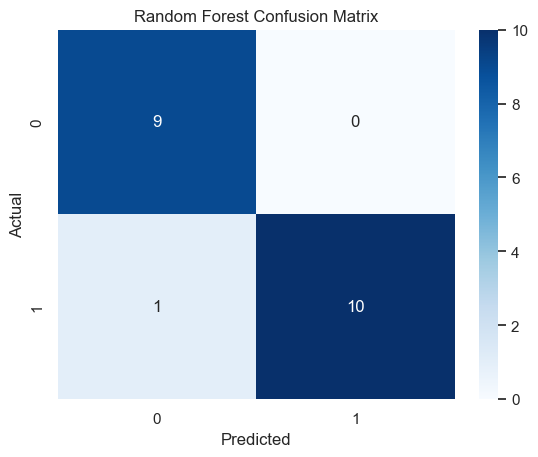

In [14]:
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


In [15]:
pickle.dump(rf, open("../model.pkl", "wb"))
pickle.dump(scaler, open("../scaler.pkl", "wb"))
